<a href="https://colab.research.google.com/github/fjojensen/02456DL_PONG/blob/master/Dueling_DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import animation
from collections import deque
import time
import torch.nn as nn
import torch
cuda = torch.cuda.is_available()
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from functools import reduce
import torch.nn.functional as F

In [15]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
env = gym.make("PongDeterministic-v4")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# dueling used by Higgsfield (cf. https://github.com/higgsfield/RL-Adventure/blob/master/3.dueling%20dqn.ipynb)
def compute_loss(ss, aa, rr, ss1, dd):
    for i in range(len(aa)):
        if aa[i] > 0: aa[i] -= 1
            
    state      = Variable(torch.from_numpy(np.stack(ss)).float().to(device))
    next_state = Variable(torch.from_numpy(np.stack(ss1)).float().to(device))
    action     = Variable(torch.from_numpy(np.stack(aa)).long().to(device))
    reward     = Variable(torch.from_numpy(np.stack(rr)).float().to(device))
    done       = Variable(torch.from_numpy(np.stack(dd)).float().to(device))

    q_values      = policy_dqn(state)
    q_values_next = policy_dqn(next_state)
    next_q_values = target_dqn(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.gather(1, torch.max(q_values_next, 1)[1].unsqueeze(1)).squeeze(1)

    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
        
    policy_dqn.optimizer.zero_grad()
    loss.backward()
    policy_dqn.optimizer.step()
    
    return loss

In [0]:
# preprocessing used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)

In [0]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)

    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

replay #: 1000


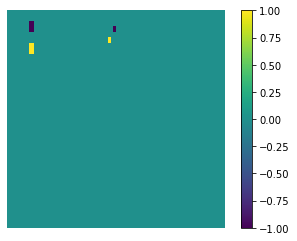

replay #: 2000


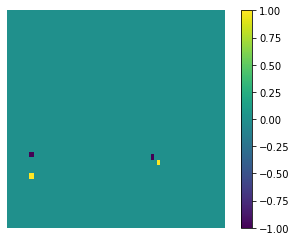

replay #: 3000


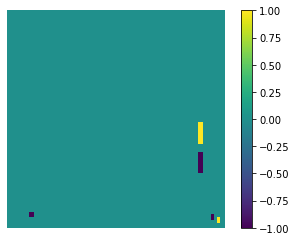

replay #: 4000


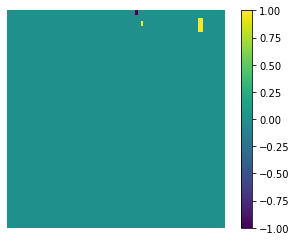

replay #: 5000


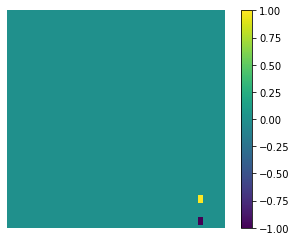

replay #: 6000


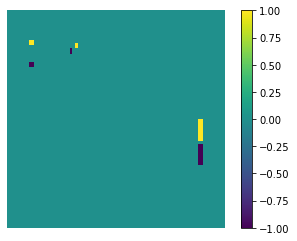

replay #: 7000


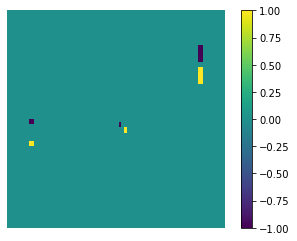

replay #: 8000


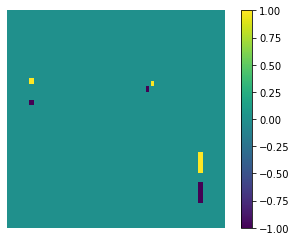

replay #: 9000


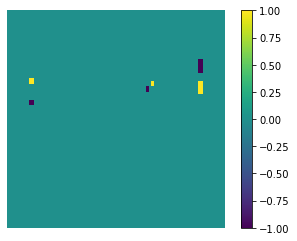

replay #: 10000


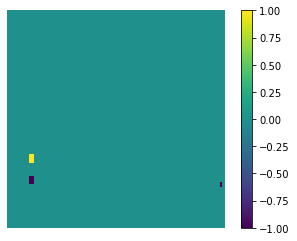

In [20]:
replay_memory_capacity = 50000
prefill_memory = True

replay_memory = ReplayMemory(replay_memory_capacity)

def sample_action():
    n = np.random.uniform(0,1)
    if n <= 1/3:
        return 0
    elif n <= 2/3:
        return 2
    else:
        return 3

if prefill_memory:

    env.reset()
    prev_input = np.zeros((80,80))
    for i in range(15):
        env.step(0)
    state0,_,_,_ = env.step(0)
    cur_input = prepro(state0)
    state = (cur_input - prev_input).reshape(1,80,80)
    prev_input = cur_input 

    while replay_memory.count() <= 0.2*replay_memory_capacity:
        action = sample_action()
        state_raw, reward, done, _ = env.step(action)
        cur_input = prepro(state_raw)
        state1 = (cur_input - prev_input).reshape(1,80,80)
        replay_memory.add(state, action, reward, state1, done)
        if not done:
            prev_input,state = cur_input,state1
        else:
            env.reset()
            for i in range(15):
                env.step(0)
            state_raw,_,_,_ = env.step(0)
            prev_input = prepro(state_raw).reshape(1,80,80)
            state = prev_input
            
        if replay_memory.count() % 1000 == 0:
            print('replay #:',replay_memory.count())
            patch = plt.imshow(state1[0])
            plt.axis('off')
            plt.colorbar()
            plt.show()

In [0]:
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x

In [0]:
class DuelingCnnDQN(nn.Module):
    def __init__(self, input_features = 1568, output_layer = 3):
        super(DuelingCnnDQN,self).__init__()

        self.out = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 1)
        )
            

            
        self.advantage = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, output_layer)
        )

        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=4, kernel_size = 5, stride = 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(4,16,5,2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16,32,5,2),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self,x):
        x = self.convolutions(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        out = self.out(x)
        return out + advantage - advantage.mean()

    #sum squared diff
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self,new_params,tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [0]:
num_episodes = 1000
episode_limit = 1100
batch_size = 32
epsilon = 1
epsilon_start = 1
epsilon_end = 0.02
epsilon_decay_rate = 150*1000
frames_list = []
epsilon_greedy = 1/(num_episodes*0.5)


step_play = 4
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
replay_memory_capacity = 10000
prefill_memory = True
val_freq = 50 # validation frequency
capture = True


# initialize DQN and replay memory
policy_dqn = DuelingCnnDQN().to(device)
target_dqn = DuelingCnnDQN().to(device)

target_dqn.load_state_dict(policy_dqn.state_dict())

policy_dqn.optimizer = optim.Adam(policy_dqn.parameters(),lr=0.0001)

rewards, lengths, losses, epsilons = [], [], [], []

In [0]:
load = False

if load:
    model_save_name = 'classifier.pt'
    path = F"/content/gdrive/My Drive/" + model_save_name

    checkpoint = torch.load(path)
    policy_dqn.load_state_dict(checkpoint['policy_dqn'])
    target_dqn.load_state_dict(checkpoint['target_dqn'])
    policy_dqn.optimizer.load_state_dict(checkpoint['optimizer'])
    replay_memory = checkpoint['replay_mem']
    episode = checkpoint['epoch']
    epsilon = checkpoint['epsilon']
    loss = checkpoint['loss']

In [0]:
def save_frames_as_gif(frames, filename=None):
    """
    Save a list of frames as a gif
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename:
        anim.save(filename, dpi=72, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


10:01:14 01/03/20 Episode:, 1, reward:,-19.0, frames: ,1500, epsilon: ,0.994, last_100_avgR: ,-19.0
10:01:29 01/03/20 Episode:, 2, reward:,-20.0, frames: ,1356, epsilon: ,0.987, last_100_avgR: ,-19.5
10:01:34 01/03/20 Episode:, 3, reward:,-21.0, frames: ,1573, epsilon: ,0.981, last_100_avgR: ,-20.0
10:01:38 01/03/20 Episode:, 4, reward:,-21.0, frames: ,1302, epsilon: ,0.974, last_100_avgR: ,-20.25
10:01:41 01/03/20 Episode:, 5, reward:,-21.0, frames: ,1122, epsilon: ,0.968, last_100_avgR: ,-20.4
10:01:48 01/03/20 Episode:, 6, reward:,-18.0, frames: ,2004, epsilon: ,0.962, last_100_avgR: ,-20.0
10:01:54 01/03/20 Episode:, 7, reward:,-20.0, frames: ,1902, epsilon: ,0.955, last_100_avgR: ,-20.0
10:01:59 01/03/20 Episode:, 8, reward:,-20.0, frames: ,1632, epsilon: ,0.949, last_100_avgR: ,-20.0
10:02:03 01/03/20 Episode:, 9, reward:,-21.0, frames: ,1212, epsilon: ,0.943, last_100_avgR: ,-20.11111111111111
10:02:09 01/03/20 Episode:, 10, reward:,-20.0, frames: ,1812, epsilon: ,0.937, last_10

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


10:05:38 01/03/20 Episode:, 51, reward:,-19.0, frames: ,1860, epsilon: ,0.717, last_100_avgR: ,-20.19607843137255
10:06:01 01/03/20 Episode:, 52, reward:,-21.0, frames: ,1393, epsilon: ,0.712, last_100_avgR: ,-20.21153846153846
10:06:06 01/03/20 Episode:, 53, reward:,-20.0, frames: ,1626, epsilon: ,0.708, last_100_avgR: ,-20.20754716981132
10:06:12 01/03/20 Episode:, 54, reward:,-20.0, frames: ,1626, epsilon: ,0.703, last_100_avgR: ,-20.203703703703702
10:06:18 01/03/20 Episode:, 55, reward:,-21.0, frames: ,1938, epsilon: ,0.699, last_100_avgR: ,-20.21818181818182
10:06:26 01/03/20 Episode:, 56, reward:,-18.0, frames: ,2274, epsilon: ,0.694, last_100_avgR: ,-20.178571428571427
10:06:31 01/03/20 Episode:, 57, reward:,-19.0, frames: ,1681, epsilon: ,0.69, last_100_avgR: ,-20.157894736842106
10:06:40 01/03/20 Episode:, 58, reward:,-18.0, frames: ,2553, epsilon: ,0.685, last_100_avgR: ,-20.120689655172413
10:06:45 01/03/20 Episode:, 59, reward:,-19.0, frames: ,1677, epsilon: ,0.681, last_1

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


10:11:59 01/03/20 Episode:, 101, reward:,-18.0, frames: ,3003, epsilon: ,0.518, last_100_avgR: ,-19.72
10:12:45 01/03/20 Episode:, 102, reward:,-20.0, frames: ,2353, epsilon: ,0.514, last_100_avgR: ,-19.72
10:12:54 01/03/20 Episode:, 103, reward:,-18.0, frames: ,2550, epsilon: ,0.511, last_100_avgR: ,-19.69
10:13:01 01/03/20 Episode:, 104, reward:,-20.0, frames: ,2256, epsilon: ,0.508, last_100_avgR: ,-19.68
10:13:11 01/03/20 Episode:, 105, reward:,-19.0, frames: ,2679, epsilon: ,0.504, last_100_avgR: ,-19.66
10:13:20 01/03/20 Episode:, 106, reward:,-17.0, frames: ,2784, epsilon: ,0.501, last_100_avgR: ,-19.65
10:13:30 01/03/20 Episode:, 107, reward:,-17.0, frames: ,2868, epsilon: ,0.498, last_100_avgR: ,-19.62
10:13:38 01/03/20 Episode:, 108, reward:,-19.0, frames: ,2400, epsilon: ,0.494, last_100_avgR: ,-19.61
10:13:47 01/03/20 Episode:, 109, reward:,-18.0, frames: ,2640, epsilon: ,0.491, last_100_avgR: ,-19.58
10:13:54 01/03/20 Episode:, 110, reward:,-20.0, frames: ,2082, epsilon: ,

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


10:20:30 01/03/20 Episode:, 151, reward:,-16.0, frames: ,2473, epsilon: ,0.374, last_100_avgR: ,-18.94
10:21:25 01/03/20 Episode:, 152, reward:,-16.0, frames: ,3285, epsilon: ,0.371, last_100_avgR: ,-18.89
10:21:34 01/03/20 Episode:, 153, reward:,-16.0, frames: ,2652, epsilon: ,0.369, last_100_avgR: ,-18.85
10:21:46 01/03/20 Episode:, 154, reward:,-16.0, frames: ,3198, epsilon: ,0.366, last_100_avgR: ,-18.81
10:21:56 01/03/20 Episode:, 155, reward:,-18.0, frames: ,2821, epsilon: ,0.364, last_100_avgR: ,-18.78
10:22:05 01/03/20 Episode:, 156, reward:,-18.0, frames: ,2550, epsilon: ,0.362, last_100_avgR: ,-18.78
10:22:16 01/03/20 Episode:, 157, reward:,-17.0, frames: ,3147, epsilon: ,0.359, last_100_avgR: ,-18.76
10:22:31 01/03/20 Episode:, 158, reward:,-14.0, frames: ,4117, epsilon: ,0.357, last_100_avgR: ,-18.72
10:22:40 01/03/20 Episode:, 159, reward:,-17.0, frames: ,2611, epsilon: ,0.355, last_100_avgR: ,-18.7
10:22:55 01/03/20 Episode:, 160, reward:,-12.0, frames: ,4221, epsilon: ,0

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


10:31:44 01/03/20 Episode:, 201, reward:,-14.0, frames: ,4116, epsilon: ,0.27, last_100_avgR: ,-17.39
10:33:17 01/03/20 Episode:, 202, reward:,-13.0, frames: ,4893, epsilon: ,0.268, last_100_avgR: ,-17.32
10:33:29 01/03/20 Episode:, 203, reward:,-17.0, frames: ,3225, epsilon: ,0.266, last_100_avgR: ,-17.31
10:33:41 01/03/20 Episode:, 204, reward:,-16.0, frames: ,3385, epsilon: ,0.264, last_100_avgR: ,-17.27
10:33:59 01/03/20 Episode:, 205, reward:,-11.0, frames: ,4728, epsilon: ,0.263, last_100_avgR: ,-17.19
10:34:14 01/03/20 Episode:, 206, reward:,-18.0, frames: ,4083, epsilon: ,0.261, last_100_avgR: ,-17.2
10:34:25 01/03/20 Episode:, 207, reward:,-17.0, frames: ,3055, epsilon: ,0.259, last_100_avgR: ,-17.2
10:34:39 01/03/20 Episode:, 208, reward:,-15.0, frames: ,3795, epsilon: ,0.258, last_100_avgR: ,-17.16
10:34:51 01/03/20 Episode:, 209, reward:,-16.0, frames: ,3378, epsilon: ,0.256, last_100_avgR: ,-17.14
10:35:08 01/03/20 Episode:, 210, reward:,-16.0, frames: ,4464, epsilon: ,0.2

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


10:46:45 01/03/20 Episode:, 251, reward:,-11.0, frames: ,5532, epsilon: ,0.195, last_100_avgR: ,-14.48
10:48:53 01/03/20 Episode:, 252, reward:,-8.0, frames: ,5262, epsilon: ,0.193, last_100_avgR: ,-14.4
10:49:09 01/03/20 Episode:, 253, reward:,-14.0, frames: ,4293, epsilon: ,0.192, last_100_avgR: ,-14.38
10:49:33 01/03/20 Episode:, 254, reward:,2.0, frames: ,6600, epsilon: ,0.191, last_100_avgR: ,-14.2
10:49:50 01/03/20 Episode:, 255, reward:,-14.0, frames: ,4845, epsilon: ,0.19, last_100_avgR: ,-14.16
10:50:09 01/03/20 Episode:, 256, reward:,-8.0, frames: ,5253, epsilon: ,0.188, last_100_avgR: ,-14.06
10:50:33 01/03/20 Episode:, 257, reward:,-5.0, frames: ,6480, epsilon: ,0.187, last_100_avgR: ,-13.94
10:50:53 01/03/20 Episode:, 258, reward:,-9.0, frames: ,5562, epsilon: ,0.186, last_100_avgR: ,-13.89
10:51:14 01/03/20 Episode:, 259, reward:,-7.0, frames: ,5947, epsilon: ,0.185, last_100_avgR: ,-13.79
10:51:27 01/03/20 Episode:, 260, reward:,-15.0, frames: ,3432, epsilon: ,0.184, las

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


11:05:09 01/03/20 Episode:, 301, reward:,13.0, frames: ,4044, epsilon: ,0.14, last_100_avgR: ,-6.91
11:07:02 01/03/20 Episode:, 302, reward:,5.0, frames: ,6174, epsilon: ,0.14, last_100_avgR: ,-6.73
11:07:26 01/03/20 Episode:, 303, reward:,4.0, frames: ,6600, epsilon: ,0.139, last_100_avgR: ,-6.52
11:07:43 01/03/20 Episode:, 304, reward:,9.0, frames: ,4782, epsilon: ,0.138, last_100_avgR: ,-6.27
11:08:05 01/03/20 Episode:, 305, reward:,5.0, frames: ,6000, epsilon: ,0.137, last_100_avgR: ,-6.11
11:08:26 01/03/20 Episode:, 306, reward:,8.0, frames: ,5940, epsilon: ,0.136, last_100_avgR: ,-5.85
11:08:46 01/03/20 Episode:, 307, reward:,8.0, frames: ,5473, epsilon: ,0.135, last_100_avgR: ,-5.6
11:09:10 01/03/20 Episode:, 308, reward:,5.0, frames: ,6600, epsilon: ,0.134, last_100_avgR: ,-5.4
11:09:31 01/03/20 Episode:, 309, reward:,4.0, frames: ,5863, epsilon: ,0.133, last_100_avgR: ,-5.2
11:09:55 01/03/20 Episode:, 310, reward:,1.0, frames: ,6600, epsilon: ,0.132, last_100_avgR: ,-5.03
11:1

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


11:22:58 01/03/20 Episode:, 351, reward:,11.0, frames: ,5037, epsilon: ,0.101, last_100_avgR: ,3.74
11:25:24 01/03/20 Episode:, 352, reward:,14.0, frames: ,4980, epsilon: ,0.101, last_100_avgR: ,3.96
11:25:44 01/03/20 Episode:, 353, reward:,7.0, frames: ,5529, epsilon: ,0.1, last_100_avgR: ,4.17
11:26:08 01/03/20 Episode:, 354, reward:,4.0, frames: ,6588, epsilon: ,0.099, last_100_avgR: ,4.19
11:26:32 01/03/20 Episode:, 355, reward:,9.0, frames: ,6600, epsilon: ,0.099, last_100_avgR: ,4.42
11:26:53 01/03/20 Episode:, 356, reward:,7.0, frames: ,5719, epsilon: ,0.098, last_100_avgR: ,4.57
11:27:11 01/03/20 Episode:, 357, reward:,14.0, frames: ,4971, epsilon: ,0.097, last_100_avgR: ,4.76
11:27:34 01/03/20 Episode:, 358, reward:,12.0, frames: ,6163, epsilon: ,0.097, last_100_avgR: ,4.97
11:27:50 01/03/20 Episode:, 359, reward:,12.0, frames: ,4435, epsilon: ,0.096, last_100_avgR: ,5.16
11:28:07 01/03/20 Episode:, 360, reward:,14.0, frames: ,4707, epsilon: ,0.096, last_100_avgR: ,5.45
11:28:

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


11:40:44 01/03/20 Episode:, 401, reward:,2.0, frames: ,6246, epsilon: ,0.073, last_100_avgR: ,9.51
11:43:47 01/03/20 Episode:, 402, reward:,15.0, frames: ,4201, epsilon: ,0.073, last_100_avgR: ,9.61
11:44:01 01/03/20 Episode:, 403, reward:,16.0, frames: ,3690, epsilon: ,0.072, last_100_avgR: ,9.73
11:44:14 01/03/20 Episode:, 404, reward:,18.0, frames: ,3681, epsilon: ,0.072, last_100_avgR: ,9.82
11:44:29 01/03/20 Episode:, 405, reward:,16.0, frames: ,3966, epsilon: ,0.071, last_100_avgR: ,9.93
11:44:46 01/03/20 Episode:, 406, reward:,9.0, frames: ,4698, epsilon: ,0.071, last_100_avgR: ,9.94
11:45:02 01/03/20 Episode:, 407, reward:,14.0, frames: ,4251, epsilon: ,0.07, last_100_avgR: ,10.0
11:45:20 01/03/20 Episode:, 408, reward:,11.0, frames: ,5046, epsilon: ,0.07, last_100_avgR: ,10.06
11:45:39 01/03/20 Episode:, 409, reward:,13.0, frames: ,5031, epsilon: ,0.069, last_100_avgR: ,10.15
11:45:58 01/03/20 Episode:, 410, reward:,12.0, frames: ,5259, epsilon: ,0.069, last_100_avgR: ,10.26
1

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


11:57:32 01/03/20 Episode:, 451, reward:,12.0, frames: ,4813, epsilon: ,0.053, last_100_avgR: ,12.5
12:00:05 01/03/20 Episode:, 452, reward:,19.0, frames: ,3714, epsilon: ,0.052, last_100_avgR: ,12.55
12:00:26 01/03/20 Episode:, 453, reward:,7.0, frames: ,5793, epsilon: ,0.052, last_100_avgR: ,12.55
12:00:50 01/03/20 Episode:, 454, reward:,6.0, frames: ,6600, epsilon: ,0.052, last_100_avgR: ,12.57
12:01:04 01/03/20 Episode:, 455, reward:,17.0, frames: ,3822, epsilon: ,0.051, last_100_avgR: ,12.65
12:01:19 01/03/20 Episode:, 456, reward:,18.0, frames: ,4041, epsilon: ,0.051, last_100_avgR: ,12.76
12:01:37 01/03/20 Episode:, 457, reward:,13.0, frames: ,4932, epsilon: ,0.051, last_100_avgR: ,12.75
12:01:59 01/03/20 Episode:, 458, reward:,12.0, frames: ,5979, epsilon: ,0.05, last_100_avgR: ,12.75
12:02:13 01/03/20 Episode:, 459, reward:,19.0, frames: ,3810, epsilon: ,0.05, last_100_avgR: ,12.82
12:02:34 01/03/20 Episode:, 460, reward:,13.0, frames: ,5829, epsilon: ,0.05, last_100_avgR: ,12

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


12:13:06 01/03/20 Episode:, 501, reward:,17.0, frames: ,3991, epsilon: ,0.038, last_100_avgR: ,15.18
12:15:24 01/03/20 Episode:, 502, reward:,20.0, frames: ,3657, epsilon: ,0.038, last_100_avgR: ,15.23
12:15:37 01/03/20 Episode:, 503, reward:,18.0, frames: ,3678, epsilon: ,0.038, last_100_avgR: ,15.25
12:15:53 01/03/20 Episode:, 504, reward:,15.0, frames: ,4368, epsilon: ,0.037, last_100_avgR: ,15.22
12:16:09 01/03/20 Episode:, 505, reward:,18.0, frames: ,4308, epsilon: ,0.037, last_100_avgR: ,15.24
12:16:21 01/03/20 Episode:, 506, reward:,20.0, frames: ,3301, epsilon: ,0.037, last_100_avgR: ,15.35
12:16:34 01/03/20 Episode:, 507, reward:,20.0, frames: ,3657, epsilon: ,0.037, last_100_avgR: ,15.41
12:16:46 01/03/20 Episode:, 508, reward:,20.0, frames: ,3109, epsilon: ,0.036, last_100_avgR: ,15.5
12:17:00 01/03/20 Episode:, 509, reward:,18.0, frames: ,3858, epsilon: ,0.036, last_100_avgR: ,15.55
12:17:15 01/03/20 Episode:, 510, reward:,18.0, frames: ,4039, epsilon: ,0.036, last_100_avgR

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


12:26:46 01/03/20 Episode:, 551, reward:,17.0, frames: ,4176, epsilon: ,0.028, last_100_avgR: ,16.95
12:29:19 01/03/20 Episode:, 552, reward:,17.0, frames: ,4266, epsilon: ,0.027, last_100_avgR: ,16.93
12:29:31 01/03/20 Episode:, 553, reward:,21.0, frames: ,3150, epsilon: ,0.027, last_100_avgR: ,17.07
12:29:42 01/03/20 Episode:, 554, reward:,20.0, frames: ,3205, epsilon: ,0.027, last_100_avgR: ,17.21
12:29:53 01/03/20 Episode:, 555, reward:,21.0, frames: ,2979, epsilon: ,0.027, last_100_avgR: ,17.25
12:30:06 01/03/20 Episode:, 556, reward:,18.0, frames: ,3678, epsilon: ,0.027, last_100_avgR: ,17.25
12:30:20 01/03/20 Episode:, 557, reward:,16.0, frames: ,3681, epsilon: ,0.026, last_100_avgR: ,17.28
12:30:31 01/03/20 Episode:, 558, reward:,20.0, frames: ,3114, epsilon: ,0.026, last_100_avgR: ,17.36
12:30:43 01/03/20 Episode:, 559, reward:,19.0, frames: ,3360, epsilon: ,0.026, last_100_avgR: ,17.36
12:30:56 01/03/20 Episode:, 560, reward:,20.0, frames: ,3390, epsilon: ,0.026, last_100_avg

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


12:39:57 01/03/20 Episode:, 601, reward:,19.0, frames: ,3978, epsilon: ,0.02, last_100_avgR: ,18.29
12:42:30 01/03/20 Episode:, 602, reward:,16.0, frames: ,3786, epsilon: ,0.02, last_100_avgR: ,18.25
12:42:42 01/03/20 Episode:, 603, reward:,21.0, frames: ,3243, epsilon: ,0.02, last_100_avgR: ,18.28
12:42:58 01/03/20 Episode:, 604, reward:,19.0, frames: ,4435, epsilon: ,0.019, last_100_avgR: ,18.32
12:43:12 01/03/20 Episode:, 605, reward:,17.0, frames: ,3915, epsilon: ,0.019, last_100_avgR: ,18.31
12:43:23 01/03/20 Episode:, 606, reward:,20.0, frames: ,3030, epsilon: ,0.019, last_100_avgR: ,18.31
12:43:37 01/03/20 Episode:, 607, reward:,18.0, frames: ,3942, epsilon: ,0.019, last_100_avgR: ,18.29
12:43:48 01/03/20 Episode:, 608, reward:,20.0, frames: ,3114, epsilon: ,0.019, last_100_avgR: ,18.29
12:44:02 01/03/20 Episode:, 609, reward:,17.0, frames: ,3903, epsilon: ,0.019, last_100_avgR: ,18.28
12:44:15 01/03/20 Episode:, 610, reward:,17.0, frames: ,3637, epsilon: ,0.019, last_100_avgR: 

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


12:53:08 01/03/20 Episode:, 651, reward:,12.0, frames: ,4170, epsilon: ,0.014, last_100_avgR: ,18.71
12:55:55 01/03/20 Episode:, 652, reward:,18.0, frames: ,3762, epsilon: ,0.014, last_100_avgR: ,18.72
12:56:07 01/03/20 Episode:, 653, reward:,21.0, frames: ,3342, epsilon: ,0.014, last_100_avgR: ,18.72
12:56:19 01/03/20 Episode:, 654, reward:,17.0, frames: ,3643, epsilon: ,0.014, last_100_avgR: ,18.69
12:56:32 01/03/20 Episode:, 655, reward:,19.0, frames: ,3534, epsilon: ,0.014, last_100_avgR: ,18.67
12:56:46 01/03/20 Episode:, 656, reward:,19.0, frames: ,3889, epsilon: ,0.014, last_100_avgR: ,18.68
12:56:57 01/03/20 Episode:, 657, reward:,19.0, frames: ,3174, epsilon: ,0.014, last_100_avgR: ,18.71
12:57:08 01/03/20 Episode:, 658, reward:,20.0, frames: ,3210, epsilon: ,0.014, last_100_avgR: ,18.71
12:57:19 01/03/20 Episode:, 659, reward:,21.0, frames: ,3145, epsilon: ,0.014, last_100_avgR: ,18.73
12:57:32 01/03/20 Episode:, 660, reward:,19.0, frames: ,3439, epsilon: ,0.014, last_100_avg

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


13:05:56 01/03/20 Episode:, 701, reward:,19.0, frames: ,3177, epsilon: ,0.01, last_100_avgR: ,19.02
13:08:15 01/03/20 Episode:, 702, reward:,17.0, frames: ,4453, epsilon: ,0.01, last_100_avgR: ,19.03
13:08:27 01/03/20 Episode:, 703, reward:,19.0, frames: ,3348, epsilon: ,0.01, last_100_avgR: ,19.01
13:08:38 01/03/20 Episode:, 704, reward:,21.0, frames: ,2976, epsilon: ,0.01, last_100_avgR: ,19.03
13:08:50 01/03/20 Episode:, 705, reward:,21.0, frames: ,3150, epsilon: ,0.01, last_100_avgR: ,19.07
13:09:01 01/03/20 Episode:, 706, reward:,20.0, frames: ,3204, epsilon: ,0.01, last_100_avgR: ,19.07
13:09:12 01/03/20 Episode:, 707, reward:,21.0, frames: ,3150, epsilon: ,0.01, last_100_avgR: ,19.1
13:09:23 01/03/20 Episode:, 708, reward:,21.0, frames: ,3151, epsilon: ,0.01, last_100_avgR: ,19.11
13:09:34 01/03/20 Episode:, 709, reward:,20.0, frames: ,3114, epsilon: ,0.01, last_100_avgR: ,19.14
13:09:45 01/03/20 Episode:, 710, reward:,21.0, frames: ,2976, epsilon: ,0.01, last_100_avgR: ,19.18
1

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


13:18:01 01/03/20 Episode:, 751, reward:,21.0, frames: ,3066, epsilon: ,0.01, last_100_avgR: ,19.46
13:20:21 01/03/20 Episode:, 752, reward:,21.0, frames: ,3249, epsilon: ,0.01, last_100_avgR: ,19.49
13:20:33 01/03/20 Episode:, 753, reward:,21.0, frames: ,3342, epsilon: ,0.01, last_100_avgR: ,19.49
13:20:44 01/03/20 Episode:, 754, reward:,21.0, frames: ,3069, epsilon: ,0.01, last_100_avgR: ,19.53
13:21:05 01/03/20 Episode:, 756, reward:,21.0, frames: ,2982, epsilon: ,0.01, last_100_avgR: ,19.57
13:21:17 01/03/20 Episode:, 757, reward:,21.0, frames: ,3162, epsilon: ,0.01, last_100_avgR: ,19.59
13:21:28 01/03/20 Episode:, 758, reward:,21.0, frames: ,3069, epsilon: ,0.01, last_100_avgR: ,19.6
13:21:40 01/03/20 Episode:, 759, reward:,19.0, frames: ,3366, epsilon: ,0.01, last_100_avgR: ,19.58
13:21:50 01/03/20 Episode:, 760, reward:,21.0, frames: ,2971, epsilon: ,0.01, last_100_avgR: ,19.6
13:22:01 01/03/20 Episode:, 761, reward:,21.0, frames: ,2985, epsilon: ,0.01, last_100_avgR: ,19.61
13

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


13:29:58 01/03/20 Episode:, 801, reward:,21.0, frames: ,3241, epsilon: ,0.01, last_100_avgR: ,19.73
13:32:31 01/03/20 Episode:, 802, reward:,20.0, frames: ,3036, epsilon: ,0.01, last_100_avgR: ,19.76
13:32:43 01/03/20 Episode:, 803, reward:,20.0, frames: ,3204, epsilon: ,0.01, last_100_avgR: ,19.77
13:32:53 01/03/20 Episode:, 804, reward:,20.0, frames: ,3024, epsilon: ,0.01, last_100_avgR: ,19.76
13:33:04 01/03/20 Episode:, 805, reward:,21.0, frames: ,2971, epsilon: ,0.01, last_100_avgR: ,19.76
13:33:15 01/03/20 Episode:, 806, reward:,21.0, frames: ,2965, epsilon: ,0.01, last_100_avgR: ,19.77
13:33:25 01/03/20 Episode:, 807, reward:,21.0, frames: ,2973, epsilon: ,0.01, last_100_avgR: ,19.77
13:33:36 01/03/20 Episode:, 808, reward:,21.0, frames: ,2970, epsilon: ,0.01, last_100_avgR: ,19.77
13:33:48 01/03/20 Episode:, 809, reward:,20.0, frames: ,3114, epsilon: ,0.01, last_100_avgR: ,19.77
13:34:03 01/03/20 Episode:, 810, reward:,18.0, frames: ,4308, epsilon: ,0.01, last_100_avgR: ,19.74


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


13:42:08 01/03/20 Episode:, 851, reward:,21.0, frames: ,2976, epsilon: ,0.01, last_100_avgR: ,19.81
13:44:38 01/03/20 Episode:, 852, reward:,21.0, frames: ,3066, epsilon: ,0.01, last_100_avgR: ,19.81
13:44:49 01/03/20 Episode:, 853, reward:,21.0, frames: ,3066, epsilon: ,0.01, last_100_avgR: ,19.81
13:45:00 01/03/20 Episode:, 854, reward:,21.0, frames: ,3060, epsilon: ,0.01, last_100_avgR: ,19.81
13:45:11 01/03/20 Episode:, 855, reward:,21.0, frames: ,3066, epsilon: ,0.01, last_100_avgR: ,19.81
13:45:22 01/03/20 Episode:, 856, reward:,21.0, frames: ,3061, epsilon: ,0.01, last_100_avgR: ,19.81
13:45:35 01/03/20 Episode:, 857, reward:,19.0, frames: ,3720, epsilon: ,0.01, last_100_avgR: ,19.79
13:45:46 01/03/20 Episode:, 858, reward:,19.0, frames: ,3180, epsilon: ,0.01, last_100_avgR: ,19.77
13:45:58 01/03/20 Episode:, 859, reward:,19.0, frames: ,3343, epsilon: ,0.01, last_100_avgR: ,19.77
13:46:11 01/03/20 Episode:, 860, reward:,13.0, frames: ,3583, epsilon: ,0.01, last_100_avgR: ,19.69


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


13:54:15 01/03/20 Episode:, 901, reward:,20.0, frames: ,3123, epsilon: ,0.01, last_100_avgR: ,19.71
13:56:57 01/03/20 Episode:, 902, reward:,21.0, frames: ,2982, epsilon: ,0.01, last_100_avgR: ,19.72
13:57:10 01/03/20 Episode:, 903, reward:,18.0, frames: ,3498, epsilon: ,0.01, last_100_avgR: ,19.7
13:57:20 01/03/20 Episode:, 904, reward:,21.0, frames: ,2982, epsilon: ,0.01, last_100_avgR: ,19.71
13:57:34 01/03/20 Episode:, 905, reward:,18.0, frames: ,3865, epsilon: ,0.01, last_100_avgR: ,19.68
13:57:46 01/03/20 Episode:, 906, reward:,19.0, frames: ,3273, epsilon: ,0.01, last_100_avgR: ,19.66
13:57:56 01/03/20 Episode:, 907, reward:,20.0, frames: ,3033, epsilon: ,0.01, last_100_avgR: ,19.65
13:58:08 01/03/20 Episode:, 908, reward:,20.0, frames: ,3126, epsilon: ,0.01, last_100_avgR: ,19.64
13:58:19 01/03/20 Episode:, 909, reward:,21.0, frames: ,3246, epsilon: ,0.01, last_100_avgR: ,19.65
13:58:32 01/03/20 Episode:, 910, reward:,16.0, frames: ,3516, epsilon: ,0.01, last_100_avgR: ,19.63
1

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


14:06:22 01/03/20 Episode:, 951, reward:,20.0, frames: ,3036, epsilon: ,0.01, last_100_avgR: ,19.74
14:09:07 01/03/20 Episode:, 952, reward:,21.0, frames: ,2982, epsilon: ,0.01, last_100_avgR: ,19.74
14:09:18 01/03/20 Episode:, 953, reward:,21.0, frames: ,2973, epsilon: ,0.01, last_100_avgR: ,19.74
14:09:30 01/03/20 Episode:, 954, reward:,20.0, frames: ,3199, epsilon: ,0.01, last_100_avgR: ,19.73
14:09:41 01/03/20 Episode:, 955, reward:,20.0, frames: ,3036, epsilon: ,0.01, last_100_avgR: ,19.72
14:09:54 01/03/20 Episode:, 956, reward:,17.0, frames: ,3732, epsilon: ,0.01, last_100_avgR: ,19.68
14:10:05 01/03/20 Episode:, 957, reward:,20.0, frames: ,3025, epsilon: ,0.01, last_100_avgR: ,19.69
14:10:19 01/03/20 Episode:, 958, reward:,18.0, frames: ,4044, epsilon: ,0.01, last_100_avgR: ,19.68
14:10:32 01/03/20 Episode:, 959, reward:,20.0, frames: ,3480, epsilon: ,0.01, last_100_avgR: ,19.69
14:10:45 01/03/20 Episode:, 960, reward:,16.0, frames: ,3609, epsilon: ,0.01, last_100_avgR: ,19.72


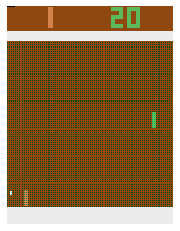

In [26]:
for episode in range(num_episodes):

    if load:
       episode += checkpoint['epoch']
    
    frames = 0
    ep_reward, ep_loss = 0, 0
    # init new episode
    env.reset()
    prev_input = np.zeros((80,80))
    for i in range(15):
        env.step(0)
    state0,_,_,_ = env.step(0)
    cur_input = prepro(state0)
    state = (cur_input - prev_input).reshape(1,80,80)
    prev_input = cur_input

    #append frames to create a giffy
    if capture: frames_list.append(state0)

    for frame in range(episode_limit):
        # select action with epsilon-greedy strategy
        for step in range(step_play):
            if np.random.rand() < epsilon:
                action = sample_action()
            else:
                with torch.no_grad():
                    s_tmp = torch.from_numpy(state.reshape(1,1,80,80)).float().to(device)
                    action = policy_dqn(s_tmp).argmax().item()
                    action +=1 if action != 0 else action 

            state_raw, reward, done, _ = env.step(action)

            # Append frames to giffy
            if capture: frames_list.append(state_raw)

            cur_input = prepro(state_raw)
            state1 = (cur_input - prev_input).reshape(1,80,80)
            replay_memory.add(state, action, reward, state1, done)
        
            state = state1
            prev_input = cur_input
            ep_reward += reward
            frames += step
            if done:
                break
                
        if replay_memory.count() >= batch_size:
            batch = replay_memory.sample(batch_size)
            for step in range(step_play):
                batch.extend(replay_memory.sample(batch_size))
            batch = np.array(batch)
            ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
            loss = compute_loss(ss, aa, rr, ss1, dd)
            target_dqn.update_params(policy_dqn.state_dict(), tau)
        ep_loss += loss.item()                 
        if done: 
            break
    if epsilon > 0.01:
        epsilon *= 0.9935
    else:
        epsilon = 0.01
    




    rewards.append(ep_reward)
    print('{} Episode:, {}, reward:,{}, frames: ,{}, epsilon: ,{}, last_{}_avgR: ,{}'.format(
        time.strftime('%X %x'),episode+1, ep_reward, frames, round(epsilon,3), 100,np.mean(rewards[-100:])))

     # save a gif
    if capture:
        gif = F"/content/gdrive/My Drive/Pong_gifs" + str(episode) + '.gif'
        save_frames_as_gif(frames_list, filename=gif)
        capture = False
        frames = []

    # frequency for when to make a giffy
    if (episode+1) % val_freq == 0: # Test setup
        frames_list, capture = [], True
        print('GIF saved')

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/" + model_save_name
torch.save({
    'epoch': episode +1,
    'policy_dqn': policy_dqn.state_dict(),
    'target_dqn': target_dqn.state_dict(),
    'optimizer': policy_dqn.optimizer.state_dict(),
    'replay_mem': replay_memory,
    'epsilon': epsilon,
    'loss': loss
}, path)